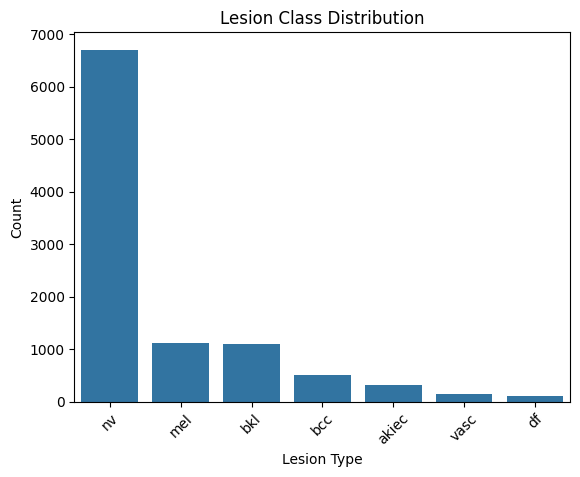

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from typing import Tuple, List, Dict
import time
# Load metadata CSV
df = pd.read_csv('C:/Users/shenl/OneDrive/Documents/Skin Cancer Prediction/HAM10000/HAM10000_metadata.csv')

# Class distribution
sns.countplot(data=df, x='dx', order=df['dx'].value_counts().index)
plt.title('Lesion Class Distribution')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [ ]:
import os

# Assume image_id column matches filenames like "ISIC_0027419.jpg"
df['image_path'] = df['image_id'].apply(lambda x: os.path.join('ham10000_images', f"{x}.jpg"))

from PIL import Image
print(df['image_path'].iloc[0])
img = Image.open(df['image_path'].iloc[0])
img.show()


In [3]:
label_mapping = {label: idx for idx, label in enumerate(df['dx'].unique())}
df['label'] = df['dx'].map(label_mapping)


In [4]:
class TrainingConfig:
    """Configuration class for training parameters"""
    def __init__(self):
        if not torch.cuda.is_available():
            raise RuntimeError("CUDA (GPU) is not available. Please run on a machine with a CUDA-capable GPU.")
        self.device = torch.device("cuda")
        self.data_dir = "ham10000_processed"
        self.batch_size = 32
        self.num_epochs = 5
        self.learning_rate = 1e-5
        self.weight_decay = 1e-4
        self.dropout_rate = 0.5
        self.label_smoothing = 0.1
        self.train_split = 0.8
        self.num_workers = 8
        self.scheduler_patience = 3
        self.scheduler_factor = 0.5

# Instantiate config
config = TrainingConfig()

In [5]:

train_df, val_df = train_test_split(
    df, test_size=1 - config.train_split, stratify=df['label'], random_state=42
)


In [6]:
from torch.utils.data import Dataset
from PIL import Image

class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert('RGB')
        label = row['label']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [7]:

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [8]:
from torch.utils.data import WeightedRandomSampler

def create_data_loaders_df(train_df, val_df, config, train_transform, val_transform):
    train_dataset = SkinDataset(train_df, transform=train_transform)
    val_dataset = SkinDataset(val_df, transform=val_transform)

    # Calculate weights for each class
    class_counts = train_df['label'].value_counts().sort_index().values
    class_weights = 1. / class_counts
    sample_weights = train_df['label'].map(lambda x: class_weights[x]).values

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        sampler=sampler,
        num_workers=config.num_workers,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True
    )
    return train_loader, val_loader


In [ ]:
# Create the balanced DataLoaders
train_loader, val_loader = create_data_loaders_df(
    train_df, val_df, config, train_transform, val_transform
)

# Test DataLoader
for i, (images, labels) in enumerate(train_loader):
    print(f"Loaded batch {i+1}", flush=True)
    if i == 2:
        break


In [ ]:
num_classes = len(train_df['label'].unique())

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Dropout(config.dropout_rate),
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(config.device)

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=config.scheduler_factor, patience=config.scheduler_patience, verbose=True
)

c:\Users\shenl\OneDrive\Documents\Skin Cancer Prediction\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import time
from torch.cuda.amp import autocast, GradScaler

# Training loop for ResNet50 with mixed precision (autocast and GradScaler)
best_val_acc = 0.0
history = []

scaler = torch.amp.GradScaler()

start_time = time.time()
for epoch in range(config.num_epochs):
    epoch_start = time.time()
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"Starting batch {batch_idx+1}/{len(train_loader)}", flush=True)
        images, labels = images.to(config.device), labels.to(config.device)
        optimizer.zero_grad()
        with torch.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        # Print progress for every batch
        print(f"Epoch [{epoch+1}/{config.num_epochs}] "
              f"Batch [{batch_idx+1}/{len(train_loader)}] "
              f"Loss: {loss.item():.4f}", flush=True)

    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(config.device), labels.to(config.device)
            with torch.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    # Scheduler step
    scheduler.step(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_skin_cancerV1.pth")

    # Store history for plotting if needed
    history.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "epoch_time": time.time() - epoch_start
    })

    print(f"Epoch [{epoch+1}/{config.num_epochs}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
          f"Time: {time.time() - epoch_start:.1f}s")

print("Training complete. Best Val Acc: {:.4f}".format(best_val_acc))
print("Total training time: {:.1f} minutes".format((time.time() - start_time) / 60))